In [1]:
import os
import requests
import re
import time
from bs4 import BeautifulSoup
import unidecode
import string
import pickle

import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk import stem
import spacy

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline


#from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer



In [2]:
def compile_urls(artist:str):
    """Function to compile the song urls for a desired artist"""
    artist_page=requests.get(f'https://www.lyrics.com/artist/{artist}').text  
    artist_soup = BeautifulSoup(artist_page, 'html.parser')
    
    links=[]
    
    for link in artist_soup.find_all(attrs={"class":"tal qx"}):
        
        #print("Collecting the lyrics. Let's not rush the server.")
        #print("Waiting for 2 seconds")
        time.sleep(2)
 
        for link in link.find_all("a"):
            link=link.get('href')
            full_link_str='https://www.lyrics.com/'+link
            
            links.append(full_link_str)
    return links

In [3]:
#def collect_lyrics(song_link:str):
def compile_lyrics(artist:str):
    
    urls = compile_urls(artist)
    print(len(urls))
    
    lyrics=[]

    for url in urls:
        #print("Collecting the lyrics. Let's not rush the server.")
        #print("Waiting for 2 seconds")
        time.sleep(2)
        
        lyrics_html=requests.get(url).text
        #print(lyrics_html)
        lyrics_soup = BeautifulSoup(lyrics_html, 'html.parser')

        for section in lyrics_soup.find_all(attrs={"class":"lyric-body"}):
            text=section.text.split()
            lyrics.append(text)
    #print(len(lyrics))
    return lyrics


In [4]:
# "Manual lemmatizer using WordNet. In the following the lemmatizer "

def nltk_lemmatize(word_list):
    """return lemmatized version of word a list"""
    
    lem = stem.WordNetLemmatizer()
    
    return [lem.lemmatize(word) for word in word_list]

In [5]:
def manual_txt_cleanup(lyrics_str):
    """clean a list of strings manually using regex expressions"""
    
    lyrics_str = lyrics_str.lower().strip()
    #lyrics_str = lyrics_str.strip()
    lyrics_str = re.sub("[\.\,\'\-!?:;\)\(]+", "", lyrics_str)
    lyrics_str = re.sub("\b\d+\b", "", lyrics_str)
    lyrics_str = re.sub('\w*\d\w*', '', lyrics_str)
    lyrics = [word for word in lyrics_str.split() if word.lower() not in stopwords.words('english')]
    lyrics_str = ' '.join(lyrics)
    lyrics_str = ' '.join( [w for w in lyrics_str.split() if len(w)>1] )
    
    return lyrics_str

In [6]:
def rmNoneElements(lst):
    for l in lst:
        if l==None:
            lst.remove(l)
    return lst

In [ ]:
# We will use Spacy to handle the text.
# i.e. tokenization, lemmatization, removal of stop words etc. 

# https://spacy.io/models/en#en_core_web_md
# English pipeline optimized for CPU.
# Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.
spacy_model = spacy.load('en_core_web_md')

In [14]:
def str_trimming(string): 
    trimmd_str = []
    token_str = spacy_model(string)
    for tkn in token_str:
        if not tkn.is_stop and not tkn.is_punct and not tkn.like_num:
            trimmd_str.append(tkn.lemma_)
    return ' '.join(trimmd_str)

In [8]:
def rm_numbers(string):
    'clean words with numbers'
    string = re.sub('\w*\d\w*', '', string)
    return string

In [9]:
def print_evaluations(X_test,y_test, model):
    """Model evaluation metrics"""
    y_pred=model.predict(X_test)

    print(f'Accuracy: {round(accuracy_score(y_test, y_pred), 3)}')
    print(f'Precision: {round(precision_score(y_test, y_pred), 3)}')
    print(f'Recall: {round(recall_score(y_test, y_pred), 3)}')
    print(f'F1-score: {round(f1_score(y_test, y_pred), 3)}')
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues,display_labels=['Metallica', 'IronMaiden'])
    
  

In [10]:
metallica_lyrics=compile_lyrics('metallica')
ironmaiden_lyrics=compile_lyrics('iron-maiden')
metallica_lyrics = rmNoneElements(metallica_lyrics)
ironmaiden_lyrics = rmNoneElements(ironmaiden_lyrics)

1588
1787


In [14]:
#lyrics_list = [metallica_lyrics, ironmaiden_lyrics]

In [11]:
for item in metallica_lyrics:
      open("metallica_raw_lyrics.txt", "a+").write(str(item)+"\n")
for item in ironmaiden_lyrics:
    open("ironmaiden_raw_lyrics.txt", "a+").write(str(item)+"\n")

In [15]:
trimmed_metallica=[]
for item in metallica_lyrics: 
    item=str_trimming(str(item))
    trimmed_metallica.append(str(item))

In [16]:
trimmed_ironmaiden=[]
for item in ironmaiden_lyrics: 
    item=str_trimming(str(item))
    trimmed_ironmaiden.append(str(item))

#### Pickling the trimmed lyrics

In [18]:
#### Pickling the trimmed lyrics
with open('trimmed_metallica.pickle', 'wb') as file:
    pickle.dump(trimmed_metallica,file)
with open('trimmed_ironmaiden.pickle', 'wb') as file:
    pickle.dump(trimmed_ironmaiden,file)

#### Reload pickled files when needed. No need to scrape the lyrics each time.

In [19]:
with open('trimmed_metallica.pickle', 'rb') as f:
      metallica = pickle.load(f)
with open('trimmed_ironmaiden.pickle', 'rb') as f:
      ironmaiden = pickle.load(f)

In [20]:
df_0=pd.DataFrame({'lyrics':metallica,  'artist':0})
df_1=pd.DataFrame({'lyrics':ironmaiden, 'artist':1})
df_main=pd.concat([df_0,df_1])

In [21]:
df_main['lyrics'] = df_main['lyrics'].apply(rm_numbers)
#splitting the data
X,y=df_main['lyrics'],df_main['artist']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=84)
X_train.shape,y_train.shape

((2530,), (2530,))

In [22]:
TfidVectzr = TfidfVectorizer()
vectorized_lyrics=TfidVectzr.fit_transform(X_train)  #creating sparse matrix
vectorized_lyrics

<2530x4065 sparse matrix of type '<class 'numpy.float64'>'
	with 118105 stored elements in Compressed Sparse Row format>

In [23]:
pickle.dump(TfidVectzr,open('TfidVectzr.pkl','wb'))

In [24]:
X_test_trans=TfidVectzr.transform(X_test).toarray()

In [25]:
# scipy.sparse.csr.csr_matrix (Compressed Sparse Row matrix)
# is not practical for printing/viewing.
# We can convert it into a dense matrix for practical purposes.
# More info:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html
tf_vectors=pd.DataFrame(vectorized_lyrics.todense().round(2), columns=TfidVectzr.get_feature_names())

## Logistic Regression

In [26]:
lreg=LogisticRegression()
lreg.fit(tf_vectors,y_train)
print("Train score :",round(lreg.score(tf_vectors,y_train),2))

Train score : 0.97


In [27]:
acc_log=round(lreg.score(X_test_trans,y_test),3)

In [28]:
accuracy=cross_val_score(lreg,tf_vectors,y_train)
print("Cross-validation score :", round(accuracy.mean(),2))

Cross-validation score : 0.96


In [29]:
#testing a song
test_song=["No more going to the dark side. With your flying saucer eyes. No more falling down a wormhole. That I have to pull you out"]
test=TfidVectzr.transform(test_song)
print(lreg.predict(test))

[0]


Accuracy: 0.97
Precision: 0.984
Recall: 0.96
F1-score: 0.972


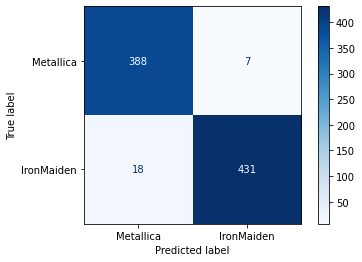

In [30]:
print_evaluations(X_test_trans, y_test, lreg)

## Multinominal Naive Bayes

In [31]:
nb = MultinomialNB()
nb.fit(tf_vectors,y_train)
print("Train score :",round(nb.score(tf_vectors,y_train),2))

Train score : 0.82


In [32]:
acc_nb=round(nb.score(X_test_trans,y_test),3) #saving for later model comparison

In [33]:
accuracy=cross_val_score(nb,tf_vectors,y_train)
print("Cross-validation score :", round(accuracy.mean(),2))

Cross-validation score : 0.81


Accuracy: 0.834
Precision: 0.764
Recall: 0.996
F1-score: 0.865


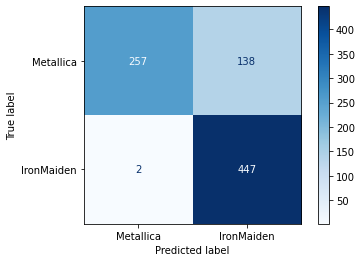

In [34]:
print_evaluations(X_test_trans, y_test, nb)

## Random Forest

In [35]:
RndmFrst = RandomForestClassifier()

In [36]:
#n_estimators = number of trees in the foreset
#max_features = max number of features considered for splitting a node
#max_depth = max number of levels in each decision tree
#min_samples_split = min number of data points placed in a node before the node is split
#min_samples_leaf = min number of data points allowed in a leaf node
#bootstrap = method for sampling data points (with or without replacement)

#searching for the best parameters
'''
forest_params = {'bootstrap': [True],
                 'max_depth': [20, 100],
                 'max_features': [2, 3],
                 'min_samples_leaf': [3, 4, 5],
                 'min_samples_split': [8, 10, 12],
                 'n_estimators': [100, 200, 300, 1000]
}
'''

forest_params = {'max_depth': range(50, 80),
                'n_estimators': range(20, 30)}

forest_grid = GridSearchCV(RndmFrst, forest_params, cv=5, verbose=True)

forest_grid.fit(tf_vectors,y_train)

forest_grid.best_params_, round(forest_grid.best_score_,2) 

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


({'max_depth': 58, 'n_estimators': 29}, 0.97)

In [37]:
forest = RandomForestClassifier(n_estimators=26, max_depth=69)

In [38]:
forest.fit(tf_vectors,y_train)
print("Train score :",round(forest.score(tf_vectors,y_train),2))

Train score : 0.98


In [39]:
pickle.dump(forest, open('rfc.pkl', 'wb'))

In [40]:
acc_rf=round(forest.score(X_test_trans,y_test),2)

In [41]:
accuracy=cross_val_score(forest,tf_vectors,y_train)
print("Cross-validation score :", round(accuracy.mean(),2))

Cross-validation score : 0.97


Accuracy: 0.976
Precision: 0.984
Recall: 0.971
F1-score: 0.978


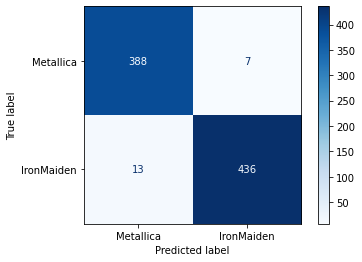

In [42]:
print_evaluations(X_test_trans, y_test, forest)

## Support Vector Machines

In [43]:
svm=svm.SVC(kernel='linear')
svm.fit(tf_vectors,y_train)
print("Train score :",round(svm.score(tf_vectors,y_train),2))

Train score : 0.98


In [44]:
acc_svm=round(svm.score(X_test_trans,y_test),2) #saving for later model comparison

In [45]:
accuracy=cross_val_score(svm,tf_vectors,y_train)
print("Cross-validation score :", round(accuracy.mean(),2))

Cross-validation score : 0.97


Accuracy: 0.981
Precision: 0.995
Recall: 0.969
F1-score: 0.982


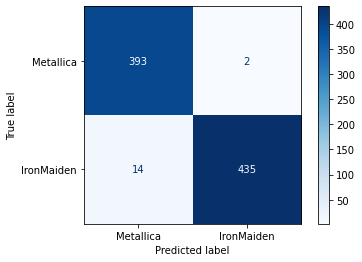

In [46]:
print_evaluations(X_test_trans, y_test, svm)

## Accuricies by models

In [47]:
models = pd.DataFrame({
    'Model': ['LR','NB', 'SVM', 'RF'],
    'Score': [acc_log, acc_nb, acc_svm, acc_rf]
})
models.sort_values(by='Score', ascending=True)

,Model,Score
1,NB,0.834
0,LR,0.970
2,SVM,0.980
3,RF,0.980


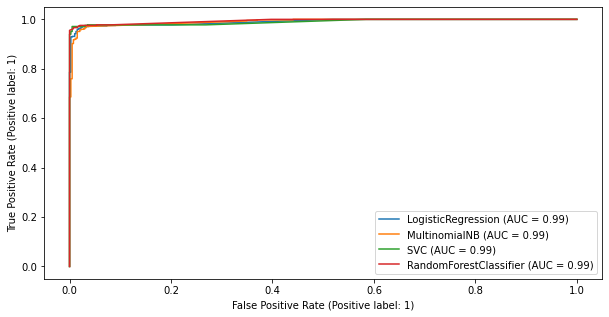

In [48]:

fig, axes = plt.subplots(1,1, figsize=(10,5))
metrics.plot_roc_curve(lreg, X_test_trans, y_test, ax=axes)
metrics.plot_roc_curve(nb, X_test_trans, y_test, ax=axes)
metrics.plot_roc_curve(svm, X_test_trans, y_test,ax=axes)
metrics.plot_roc_curve(forest, X_test_trans, y_test, ax=axes)